## Project: Time-Series Forecasting on the S&P 500

Our goal is to build a successful model to forecast how the S&P 500 index will move based on its past behavior. The dataset we're starting from is raw and hasn't had any preprocessing applied to it yet (it contains S&P 500 Index prices from 2015 through 2020).

We'll go through the specifics for preparing this dataset for a __time series forecast with RNNs__.Once the data is prepared, we'll build, train, and evaluate several forecasting models until we have achieved satisfactory performance. Finally, we'll take what we've built and visualize the output so we can see how successful our trading strategy is going to be!

### Data Wrangling and Exploration

First, we will load the dataset into our notebook and inspect the data for any data quality issues. At a minimum, we should check for:

* Missing values
* Outliers
* Whether the data is sorted by the Date column (essential for time series forecasting)

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# set random seed values to improve the reproducibility of the models
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [2]:
stock_data=pd.read_csv("C:/Users/Denisa/Desktop/Project Apps/project 26/yahoo_stock.csv")

Data Dictionary:

`Open`: the opening value of the index on that day

`High`: the highest value of the index on that day

`Low`: the lowest value of the index on that day

`Close`: the closing value of the index on that day

`Volume`: the total volume of the index traded on that day

`Adj Close`: the closing value of the index on that day adjusted for dividends

In [3]:
stock_data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [4]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


The data contains no missing values.

In [5]:
stock_data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


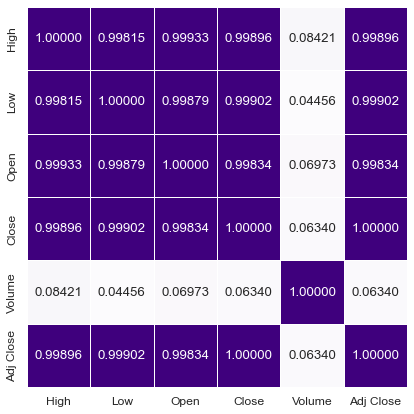

In [6]:
plt.figure(figsize=(7,7))
correlations = stock_data.corr()

sns.set(font_scale=1.1)

sns.heatmap(correlations,
            annot=True,
            fmt='.5f',
            cmap='Purples',
            square=True,
            linewidths=1,
            cbar=False)

plt.show()

We are going to use only the Adj Close column, which is the closing price of the S&P 500 index, adjusted for dividends and decide what other column(s) to use for the forecast itself.

From the heatmap above we can identify strong relationships between:
* High and Low
* High and Open
* High and Close
* Low and Open
* Low and Close
* Open and CLose

To avoid multicolinearity next we will calculate the VIF values of the previously strongly correlated features (we consider a VIF value >=5 too large).

In [7]:
# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = stock_data[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

# features to consider removing
considered_features = ['High', 'Low', 'Open', 'Close']


# compute vif 
compute_vif(considered_features).sort_values('VIF', ascending=False)

C:\Users\Denisa\AppData\Local\Temp/ipykernel_44244/4005217335.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
0,High,2080.534840
2,Open,1896.172845
3,Close,1515.922235
1,Low,1308.362849


As shown above, all have VIF values exceeding 5. We won't remove all features at once but we will remove one feature at a time to minimize information that is lost.

In [8]:
considered_features.remove('High')
compute_vif(considered_features).sort_values('VIF', ascending=False)

C:\Users\Denisa\AppData\Local\Temp/ipykernel_44244/4005217335.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
0,Low,744.743499
2,Close,542.563034
1,Open,440.962072


In [9]:
considered_features.remove('Low')
compute_vif(considered_features).sort_values('VIF', ascending=False)

C:\Users\Denisa\AppData\Local\Temp/ipykernel_44244/4005217335.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
0,Open,302.208437
1,Close,302.208437


In [10]:
considered_features.remove('Close')
compute_vif(considered_features).sort_values('VIF', ascending=False)

C:\Users\Denisa\AppData\Local\Temp/ipykernel_44244/4005217335.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
0,Open,1.0


For Now we will only use the Adj Close column.

We will set the index of the DataFrame to the Date column to prepare for time series forecasting. We should also ensure that the data is sorted by its Date column.

In [11]:
# Select relevant columns, sort data, and set index
stock_data = stock_data[["Date", "Adj Close"]]
stock_data = stock_data.sort_values("Date")
# It is recommended to put the column containing the date or time information on the index of the DataFrame for ease of plotting
stock_data = stock_data.set_index("Date")

In [12]:
#Checking for outliers
print("\nSkew: \n", stock_data.skew())


Skew: 
 Adj Close    0.081869
dtype: float64


The low skew value for Adj Close indicates we don't have any outliers to be concerned about. 

Before we begin preparing the data for modeling let's quickly visualize the data.

Text(0, 0.5, 'Adjusted Close')

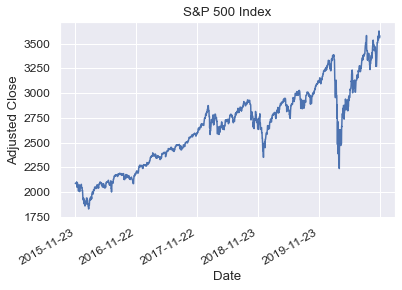

In [13]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot the data
plt.plot(stock_data)

# Add title and axis labels
plt.title('S&P 500 Index')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Adjusted Close')

We can see that we have data from about five years to work with. There are no gaps, and there are some visible spikes

There is a pattern here, and we want to build a model that can predict that pattern.

## Data Preprocessing

Next up, we need to need to prepare our clean data for modeling. This preparation requires the following four steps:

* Split data into training(50%), validation(25%), and testing(25%) sets
* Scale data to be between 0 and 1
* Create time windows for each dataset
* Reshape the data into NumPy arrays to prepare it for TensorFlow models

Next we are going to prepare your data for modeling by splitting it into three datasets: training, validation, and testing. we are using the validation set to evaluate our predictions and not the test set. This is because we want to have a clean, untouched testing dataset for our final model evaluationas it is best practice to have an untouched testing set kept aside during the model optimization process.

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Split into train, validation, and test sets
train_size = int(len(stock_data) * 0.5)
validation_size = int(len(stock_data) * 0.25)
train_df = stock_data.iloc[0:train_size, :]
validation_df = stock_data.iloc[train_size:train_size + validation_size, :]
test_df = stock_data.iloc[train_size + validation_size:len(stock_data), :]



Apply a scaler to the value to be forecasted for each dataset and fit the scaler to the training set(to prevent info about the test distribbution leaking into the model).After we fit the scaler on the training data only, we will use it to transform all three datasets: training, validation, and testing.

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_df)

# Scale data
train = pd.DataFrame(scaler.transform(train_df), columns=["Adj Close"], index=train_df.index)
validation = pd.DataFrame(scaler.transform(validation_df), columns=["Adj Close"], index=validation_df.index)
test = pd.DataFrame(scaler.transform(test_df), columns=[ "Adj Close"], index=test_df.index)

We also need to shape our data into fixed-length time windows and reshape it into NumPy arrays to prepare it for TensorFlow models.

In [16]:
# Define a helper function to construct windowed datasets
def create_dataset(dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        window = dataset.iloc[i:(i + window_size), 0]
        target = dataset.iloc[i + window_size, 0]
        data_x.append(window)
        data_y.append(target)
    return np.array(data_x), np.array(data_y)

# Set the desired window size
window_size = 10

# Construct train, validation, and test datasets
X_train, y_train = create_dataset(train, window_size)
X_validation, y_validation = create_dataset(validation, window_size)
X_test, y_test = create_dataset(test, window_size)

# Reshape into NumPy arrays
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Build and Train a Basic RNN Model

Now that data was prepared for modeling let's build a Tensorflow model. We will start with a SimpleRNN model. We will train the model using the train set, then check our performance on the validation set.

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(10, input_shape=(1, window_size), activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                210       
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Calculate a performance score using an appropriate metric for a regression task: coefficient of determination

In [19]:

# Import
from sklearn.metrics import r2_score

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_validation)
print(r2_score(y_validation, y_pred))

14/14 [==============================] - 0s 1ms/step
-92.97549395321612


The R-Squared score indicates a very poor performance.

### Build and Train an LSTM Model

Let's explore what might happen if we simply switch the recurrent layer from a SimpleRNN to an LSTM.

In [20]:
# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(10, input_shape=(1, window_size), activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_validation)
print(r2_score(y_validation, y_pred))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                840       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 961 (3.75 KB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
14/14 [==============================] - 0s 1ms/step
-60.02999289943477


Switching to LSTM still didn't improve things as we hoped.

### Add a Convolutional Layer

 Let's try adding a convolutional layer before the LSTM layer and see if that makes a difference.  We typically include a pooling layer after a convolutional layer, so this means that we'll actually be adding two layers to this model that weren't in the previous one.

In [21]:
# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(64, 1, activation="relu", input_shape=(1, window_size)))
model.add(tf.keras.layers.MaxPooling1D(1))
model.add(tf.keras.layers.LSTM(10, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_validation)
print(r2_score(y_validation, y_pred))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             704       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 64)             0         
 D)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 10)                3000      
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3825 (14.94 KB)
Trainable params: 3825 (14.94 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

The results improved but still they are not satisfactory so we will try to modify other model parameters.

### Optimize the Model

We have a number of different adjustments we can make to find the sweet spot between model performance and complexity:

* Window sizve
* Number of hidden layers
* Number of nodes per hidden layer
* Type of recurrent layer (SimpleRNN, LSTM, GRU)
* Inclusion (or not) of a convolutional layer
* Activation function used (or not) at each layer
* Optimizer
* Loss function
* Number of epochs

In [22]:
# Set the desired window size
window_size = 25

# Construct train, validation, and test datasets
X_train, y_train = create_dataset(train, window_size)
X_validation, y_validation = create_dataset(validation, window_size)
X_test, y_test = create_dataset(test, window_size)

# Reshape into NumPy arrays
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(128, 1, activation="relu", input_shape=(1, window_size)))
model.add(tf.keras.layers.MaxPooling1D(1))
model.add(tf.keras.layers.LSTM(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=35)

# Make predictions and evaluate
y_pred = model.predict(X_validation)
print(f"\nR-Squared value on validation set: {r2_score(y_validation, y_pred)}")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 128)            3328      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 128)            0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                      

We got an R-Squared value of 94.4% on the validation set.

### Evaluate Model Performance

 Now that we've created a model that we're happy with in terms of performance on the validation set, it's time to bring back the testing set and check our model performance on this completely unseen data.

In [23]:
# Make predictions on all three sets
train_pred = model.predict(X_train)
validation_pred = model.predict(X_validation)
test_pred = model.predict(X_test)

print(r2_score(y_train, train_pred), " --> Training Set")
print(r2_score(y_validation, validation_pred), " --> Validation Set")
print(r2_score(y_test, test_pred), " --> Test Set")

14/14 [==============================] - 0s 2ms/step
0.9959827832583081  --> Training Set
0.9448037185881578  --> Validation Set
0.9372842241528271  --> Test Set


The R-Squared value from validation seems to have held up in testing.

After assessing the performance metric, we should also visualize our predictions compared to the original data, as we did in the previous lesson. To do this, we need to unscale the data and adjust the indices to undo the windowing. Then, we can plot the original data and our predictions on the same axes and compare.

In [24]:
# Un-scale the predictions
train_pred = scaler.inverse_transform(train_pred)
validation_pred = scaler.inverse_transform(validation_pred)
test_pred = scaler.inverse_transform(test_pred)

# Un-window the training predictions
plot_train_pred = np.empty((len(stock_data), 1))
plot_train_pred[:] = np.nan
plot_train_pred[window_size:len(train_pred) + window_size, :] = train_pred

# Un-window the validation predictions
plot_validation_pred = np.empty((len(stock_data), 1))
plot_validation_pred[:] = np.nan
plot_validation_pred[len(train_pred) + (window_size * 2) + 1:len(train_pred) + len(validation_pred) + (window_size * 2) + 1, :] = validation_pred

# Un-window the test predictions
plot_test_pred = np.empty((len(stock_data), 1))
plot_test_pred[:] = np.nan
plot_test_pred[len(train_pred) + len(validation_pred) + (window_size * 3) + 2:len(stock_data) - 1, :] = test_pred

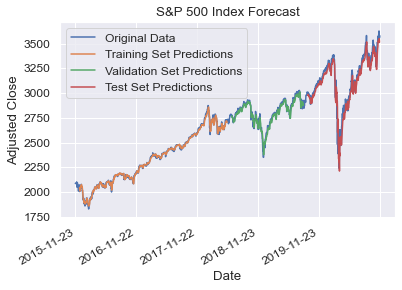

In [25]:
# Plot the original data
plt.plot(stock_data, label="Original Data")

# Plot the predictions
plt.plot(plot_train_pred, label="Training Set Predictions")
plt.plot(plot_validation_pred, label="Validation Set Predictions")
plt.plot(plot_test_pred, label="Test Set Predictions")

# Add title, axis labels, and a legend
plt.title('S&P 500 Index Forecast')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Adjusted Close')
plt.legend()
plt.show()

We've successfully produced a time series forecast with RNN's for the S&P 500 index and the performance metric indicated 93.7% on the test set.